<a href="https://colab.research.google.com/github/vvalcristina/datascience_codenation/blob/master/Projeto_pr%C3%A1tico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Projeto Final AceleraDev DataScience**

O objetivo deste produto é fornecer um serviço automatizado que recomenda leads para um usuário dado sua atual lista de clientes (Portfólio).

**Dados**: foram utilizadas 4 bases de dados.

**Realizando os imports necessários**

Vamos importar as libs necessárias para o desenvolvimento do produto e a nossa base de dados principal.

In [0]:
import functools
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy.stats as sct
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_blobs, make_classification
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import os
from google.colab import drive

In [0]:
%matplotlib inline

from IPython.core.pylabtools import figsize

figsize(12, 12)

Como estou utilizando o Google Colaboratory vou dar acesso ao meu drive para acesso ao dataset.

In [233]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
df = pd.read_csv('/content/drive/My Drive/data/estaticos_market.csv')

### **Pré-processamento dos dados**

Vamos remover os warnings do nosso dataset.


In [0]:
import warnings
warnings.filterwarnings('ignore')

**Conhecendo nosso DataSet**

Vamos obter as informações a respeito do nosso dataset. Verificar número de linhas, colunas e que tipos de variáveis temos disponíveis.

In [236]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153871 entries, 0 to 153870
Columns: 182 entries, Unnamed: 0 to qt_filiais
dtypes: bool(9), float64(145), int64(1), object(27)
memory usage: 204.4+ MB


Nossa base de dados possui 153.871 linhas, 182 colunas com tipos de variáveis diversas: boolean, float, int e variáveis categóricas. 

**Verificação e tratamento de dados nulos**

Nosso dataset possui muitas informações, a princípio, vamos verificar se existem, e se existem quantas das nossas variáveis são nulas.

In [237]:
df.isnull().sum()

Unnamed: 0                      0
id                              0
fl_matriz                       0
de_natureza_juridica            0
sg_uf                           0
                            ...  
qt_funcionarios_24meses    119447
tx_crescimento_12meses     129305
tx_crescimento_24meses     129228
tx_rotatividade            119447
qt_filiais                      1
Length: 182, dtype: int64

Como temos muitas colunas e muitos dados nulos vamos criar um dataframe auxiliar onde removeremos as colunas que possuem 50% de seus dados nulos.

A escolha do valor 50% foi uma escolha arbitrária. Escolhi retirar da análise as colunas que ṕossuem mais de 50% dos seus dados nulos. Inicialmente, retirei as colunas que possuíam 60% dos valores nulos, entretanto, ao comparar as colunas retiradas entre 60% e 50% e muda-se pouquíssima coisa (em virtude da dimensão do DataFrame) então por convenção mantive em 50%.

In [0]:
df_var_null = pd.DataFrame(df.isnull().sum()/df.shape[0], columns=['var_null'])
df_drop= df_var_null[df_var_null['var_null']>0.50]

Agora vamos verificar quais dessas colunas possuem mais de 50% dos valores nulos. Essas colunas serão retiradas da nossa análise.

In [0]:
columns_dropped = list(df_drop.transpose().columns)
columns_dropped.append('Unnamed: 0')

Vamos criar um dataframe auxiliar sem essas colunas.

In [0]:
df_dropped = df.drop(axis=1, columns=columns_dropped)

In [241]:
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153871 entries, 0 to 153870
Data columns (total 50 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     153871 non-null  object 
 1   fl_matriz                              153871 non-null  bool   
 2   de_natureza_juridica                   153871 non-null  object 
 3   sg_uf                                  153871 non-null  object 
 4   natureza_juridica_macro                153871 non-null  object 
 5   de_ramo                                153871 non-null  object 
 6   setor                                  153272 non-null  object 
 7   idade_empresa_anos                     153871 non-null  float64
 8   idade_emp_cat                          153871 non-null  object 
 9   fl_me                                  153871 non-null  bool   
 10  fl_sa                                  153871 non-null  

**Análise das colunas do Dataframe**

Nosso novo dataframe (**df_dropped**) agora possui 50 colunas, uma redução considerável que torna mais simples nossa análise. 

Entretanto, precisamos analisar as colunas disponíveis: 
* Realmente precisamos de todas para análise? 
* Elas possuem dados faltantes?
* Há informações redundantes?

In [242]:
df_dropped.isnull().sum()

id                                           0
fl_matriz                                    0
de_natureza_juridica                         0
sg_uf                                        0
natureza_juridica_macro                      0
de_ramo                                      0
setor                                      599
idade_empresa_anos                           0
idade_emp_cat                                0
fl_me                                        0
fl_sa                                        0
fl_epp                                       0
fl_mei                                       0
fl_ltda                                      0
dt_situacao                                  2
fl_st_especial                               0
fl_email                                     0
fl_telefone                                  0
fl_rm                                        0
nm_divisao                                 599
nm_segmento                                599
fl_spa       

**Variáveis removidas do Dataframe após análise**

Após a análise das variáveis do datafreme foram removidas as seguintes variáveis do Dataframe.

* **fl_matriz**: corresponde a uma matriz booleana de CNPJ, o que acredito não ser tão relevante para o contexto do projeto.
* **de_natureza_juridica**: possuímos a variável **natureza_juridica_macro** que descreve as mesmas informações dessa coluna em uma forma mais ampla, tornando nossa anális mais abrangente.
* **de_ramo, nm_divisao, nm_segmento**: é uma variável relevante, entretanto é uma variável muito específica, mas como escolhi manter a variável **setor**, por ser uma variável mais ampla seria incoerente mantê-la no dataset.
* **idade_empresa_anos**: é uma variável relevante, entretanto há variáveis equivalentes em intervalos mais abrangentes, como por exemplo **idade_emp_cat**.
* **fl_me, fl_sa, fl_epp, fl_mei, fl_ltda, fl_optante_simei, fl_simples_irregular**: essas variáveis contém informações relevantes ao tamanho da empresa, entretanto, como são valores booleanos e a maioria estão anotados como False e há uma outra variável(**de_faixa_faturamento_estimado_grupo**) que contém informações mais amplas sobre o tamanho da empresa.
* **dt_situacao**: acredito que essa variável não é relevante para o contexto do problema.
* **fl_st_especial**: acredito que essa variável não é relevante para o contexto do problema, além disso, a maioria dos valores é denotado como False.
* **fl_email, fl_telefone, fl_spa, fl_antt, fl_veiculo**:  variável booleana que acredito não ser relevante para o contexto do problema.
* **fl_optante_simples**: variável booleana, com a grande maioria de seus valores nulos que não acredito ser relevante para o contexto do problema.
* **vl_total_veiculos_pesados_grupo**: a variável não é relevante para o contexto do problema, dado que a maioria das empresas não posssui frota declarada de veículos pesados.
* **vl_total_veiculos_leves_grupo**: a variável não é relevante para o contexto do problema, dado que a maioria das empresas não posssui frota declarada de veículos leves.
* **sg_uf_matriz**:  os dados são a respeito da matriz e como escolhi considerar na análise as informações da variável **sg_uf**, seriam informações redundantes.
* **de_saude_rescencia**: não há uma variabilidade dos dados, o que acaba não  agregando muito significado para nossa análise. Mais de 90% dos valores são denotados por 'ACIMA DE 1 ANO'.
* **nu_meses_rescencia**: dado ao fato de ter escolhido não analisar **de_saude)rescência** pelos dados não apresentarem variabilidade, a escolha dessa variável parece interessante. Entretanto, como ela possui a grande maioria de seus dados nulos não faz muito sentido ser mantida na análise.
* **empsetorcensitariofaixarendapopulacao**: para o contexto da análise, acredito que essa variável não é relevante. 
* **nm_micro_regiao e nm_meso_regiao**: são informações relevantes, mas como escolhi analisar os dados pela região metropolitana (onde não possuo nenhuma variável nula) esses dados seriam redundantes na análise. 
*  **fl_simples_irregular**: fornece informações se a empresa apresenta irregularidades é interessante mas cerca de 99% dos valores são denotados como False. Como não possui grande variabilidade não é interessante para a análise.
* **qt_filiais**: representa as a quantidade de filiais da empresa, o que é relevante quando pensamos no tamanho, mas como possuímos outras variáveis não é tão relevante para a nossa análise.

In [0]:
columns_dropped = ['fl_matriz', 'de_natureza_juridica', 'de_ramo', 'idade_empresa_anos', 'fl_rm','fl_me', 'fl_sa', 'fl_epp', 'fl_mei', 
                   'fl_ltda', 'dt_situacao', 'fl_st_especial','fl_email','fl_telefone', 'nm_divisao', 'nm_segmento', 
                   'fl_spa','fl_antt', 'fl_veiculo', 'fl_optante_simples', 'vl_total_veiculos_pesados_grupo',
                   'vl_total_veiculos_leves_grupo', 'fl_optante_simei','sg_uf_matriz', 'de_saude_rescencia', 'nu_meses_rescencia',
                   'empsetorcensitariofaixarendapopulacao', 'nm_meso_regiao', 'nm_micro_regiao', 'fl_passivel_iss', 'qt_socios',
                   'qt_socios_pf', 'qt_socios_pj','idade_media_socios', 'idade_maxima_socios', 'idade_minima_socios', 
                   'qt_socios_st_regular', 'de_faixa_faturamento_estimado', 'vl_faturamento_estimado_aux', 
                   'vl_faturamento_estimado_grupo_aux', 'fl_simples_irregular', 'qt_filiais']

In [0]:
df_market= df_dropped.drop(axis=1, columns=columns_dropped)

**Variáveis escolhidas**

Após as análises das 50 variáveis resultantes, foram mantidas as variáveis que considerei relevantes para o produto.

* **id:** É o identificador de cada uma das empresas de nossa base.
sg_uf: Contém a sigla sobre cada estado que se encontram as empresas de nossa base de dados.
* **natureza_juridica_macro**: Apresenta a natureza jurídica em que cada empresa está inserida.
* **setor**: Representa o setor (amplo) que cada empresa está inserida.
* **idade_emp_cat**: Representa o range de anos daquela empresa no mercado.
* **de_saude_tributaria**: fornece informações a respeito da saúde tributária de cada empresa. Onde VERDE representa uma boa saúde e VERMELHA ruim.
de_nivel_atividade: fornece informações sobre as atividades da empresa (pistas sobre fluxo de caixa).
* **de_faixa_faturamento_estimado_grupo**: fornece informações a respeito do faturamento daquela empresa, o que nos diz sobre seu tamanho, saúde financeira e outras informações.


In [245]:
df_market.columns

Index(['id', 'sg_uf', 'natureza_juridica_macro', 'setor', 'idade_emp_cat',
       'de_saude_tributaria', 'de_nivel_atividade',
       'de_faixa_faturamento_estimado_grupo'],
      dtype='object')

Após as escolhas das variáveis criamos um novo dataset auxiliar para o próximo passo das nossas análises.

In [246]:
df_market.head()

,id,sg_uf,natureza_juridica_macro,setor,idade_emp_cat,de_saude_tributaria,de_nivel_atividade,de_faixa_faturamento_estimado_grupo
0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,RN,ENTIDADES EMPRESARIAIS,CONSTRUÇÃO CIVIL,10 a 15,VERDE,ALTA,"DE R$ 1.500.000,01 A R$ 4.800.000,00"
1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,PI,OUTROS,SERVIÇO,1 a 5,CINZA,BAIXA,"DE R$ 81.000,01 A R$ 360.000,00"
2,4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02...,AM,OUTROS,SERVIÇO,5 a 10,AMARELO,MEDIA,"ATE R$ 81.000,00"
3,3348900fe63216a439d2e5238c79ddd46ede454df7b9d8...,AM,OUTROS,SERVIÇO,5 a 10,AMARELO,MEDIA,"DE R$ 81.000,01 A R$ 360.000,00"
4,1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4...,RN,OUTROS,SERVIÇO,1 a 5,VERDE,ALTA,"DE R$ 81.000,01 A R$ 360.000,00"


### **Tratamento dos dados**

Nessa etapa vamos analisar o novo dataframe com as variáveis que iremos considerar para a aplicação de nosso modelo de recomendação. Vamos verificar se há valores nulos, como tratar nossas variáveis categóricas e aplicar redução de dimensionalidade.

In [247]:
df_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153871 entries, 0 to 153870
Data columns (total 8 columns):
 #   Column                               Non-Null Count   Dtype 
---  ------                               --------------   ----- 
 0   id                                   153871 non-null  object
 1   sg_uf                                153871 non-null  object
 2   natureza_juridica_macro              153871 non-null  object
 3   setor                                153272 non-null  object
 4   idade_emp_cat                        153871 non-null  object
 5   de_saude_tributaria                  148932 non-null  object
 6   de_nivel_atividade                   150206 non-null  object
 7   de_faixa_faturamento_estimado_grupo  144728 non-null  object
dtypes: object(8)
memory usage: 9.4+ MB


No nosso dataframe possuímos 8 colunas e 153.871 linhas. Das nossas 10 variáveis (colunas) resultantes uma delas é o ID das empresas, logo nos restam 7 variáveis. Antes de prosseguirmos nessa análise é necessário tratar essas nossas variáveis categóricas.


**Verificando as variáveis vazias(nulas)**

In [248]:
df_market.isna().sum()/df_market.shape[0]

id                                     0.000000
sg_uf                                  0.000000
natureza_juridica_macro                0.000000
setor                                  0.003893
idade_emp_cat                          0.000000
de_saude_tributaria                    0.032098
de_nivel_atividade                     0.023819
de_faixa_faturamento_estimado_grupo    0.059420
dtype: float64

Das nossas 8 colunas temos 4 que possuem valores nulos elas são: 
* setor
* de_saude_tributaria
* de_nivel_atividade
* de_faixa_faturamento_estimado_grupo

Vamos tratar cada uma delas. 

**setor**

Quando verificamos as variáveis de setor percebemos que as variáveis COMERCIO e SERVICO possuem uma distribuição similar, no entanto, optamos pela variável que possui uma maior frequência no dataset.Logo as variáveis nulas serão substituídas pela variávl COMERCIO.

In [249]:
df_market['setor'].value_counts(normalize=True)

COMERCIO            0.458871
SERVIÇO             0.410623
INDUSTRIA           0.067768
CONSTRUÇÃO CIVIL    0.055594
AGROPECUARIA        0.007144
Name: setor, dtype: float64

In [250]:
df_market['setor'].fillna(value='COMERCIO', inplace=True)
df_market['setor'].value_counts(normalize=True)

COMERCIO            0.460977
SERVIÇO             0.409024
INDUSTRIA           0.067505
CONSTRUÇÃO CIVIL    0.055378
AGROPECUARIA        0.007116
Name: setor, dtype: float64

**de_saude_tributaria**

As variáveis que compõe a saúde tributária são muito bem distribuídas, se fosse uma variável numérica o que normalmente se vê na literatura é a substituição pela média. Entretanto, como se trata de uma variável categórica elas serão substituídas pela variável com maior distribuição no dataset, neste caso VERDE.

In [251]:
df_market['de_saude_tributaria'].value_counts(normalize=True)

VERDE       0.325766
AZUL        0.236094
AMARELO     0.202905
CINZA       0.142280
LARANJA     0.080413
VERMELHO    0.012543
Name: de_saude_tributaria, dtype: float64

In [252]:
df_market['de_saude_tributaria'].fillna(value='VERDE', inplace=True)
df_market['de_saude_tributaria'].value_counts(normalize=True)

VERDE       0.347408
AZUL        0.228516
AMARELO     0.196392
CINZA       0.137713
LARANJA     0.077831
VERMELHO    0.012140
Name: de_saude_tributaria, dtype: float64

**de_nivel_atividade**

Em relação ao nível de atividade a variável que aparece com a maior frequência no dataset é a MEDIA, quase metade das variáveis se encontram denotadas como MEDIA (48,49%). Logo as variáveis nulas serão substituídas por MEDIA.

In [253]:
df_market['de_nivel_atividade'].value_counts(normalize=True)

MEDIA          0.484961
ALTA           0.336345
BAIXA          0.168402
MUITO BAIXA    0.010293
Name: de_nivel_atividade, dtype: float64

In [254]:
df_market['de_nivel_atividade'].fillna(value='MEDIA', inplace=True)
df_market['de_nivel_atividade'].value_counts(normalize=True)

MEDIA          0.497228
ALTA           0.328333
BAIXA          0.164391
MUITO BAIXA    0.010047
Name: de_nivel_atividade, dtype: float64

**de_faixa_faturamento_estimado_grupo**

Para essa variável foi utilizada a mesma estratégia anterior de aplicar a variável mais frequente no dataset para os valores nulos.

In [255]:
df_market['de_faixa_faturamento_estimado_grupo'].value_counts(normalize=True)

DE R$ 81.000,01 A R$ 360.000,00             0.580067
ATE R$ 81.000,00                            0.226978
DE R$ 360.000,01 A R$ 1.500.000,00          0.122810
DE R$ 1.500.000,01 A R$ 4.800.000,00        0.030886
DE R$ 4.800.000,01 A R$ 10.000.000,00       0.009321
DE R$ 10.000.000,01 A R$ 30.000.000,00      0.008658
ACIMA DE 1 BILHAO DE REAIS                  0.008146
DE R$ 30.000.000,01 A R$ 100.000.000,00     0.006799
DE R$ 100.000.000,01 A R$ 300.000.000,00    0.003496
DE R$ 500.000.000,01 A 1 BILHAO DE REAIS    0.001575
DE R$ 300.000.000,01 A R$ 500.000.000,00    0.001264
Name: de_faixa_faturamento_estimado_grupo, dtype: float64

In [256]:
df_market['de_faixa_faturamento_estimado_grupo'].fillna(value='DE R$ 81.000,01 A R$ 360.000,00', inplace=True)
df_market['de_faixa_faturamento_estimado_grupo'].value_counts(normalize=True)

DE R$ 81.000,01 A R$ 360.000,00             0.605020
ATE R$ 81.000,00                            0.213491
DE R$ 360.000,01 A R$ 1.500.000,00          0.115512
DE R$ 1.500.000,01 A R$ 4.800.000,00        0.029050
DE R$ 4.800.000,01 A R$ 10.000.000,00       0.008767
DE R$ 10.000.000,01 A R$ 30.000.000,00      0.008143
ACIMA DE 1 BILHAO DE REAIS                  0.007662
DE R$ 30.000.000,01 A R$ 100.000.000,00     0.006395
DE R$ 100.000.000,01 A R$ 300.000.000,00    0.003288
DE R$ 500.000.000,01 A 1 BILHAO DE REAIS    0.001482
DE R$ 300.000.000,01 A R$ 500.000.000,00    0.001189
Name: de_faixa_faturamento_estimado_grupo, dtype: float64

**Removendo o Unnamed(index) e transformando nosso ID no index**

Vamos remover o index do dataset (Unnamed) para transformar nosso ID no index do dataset. Assim nosso ID funcionará como uma espécie de chave primária do dataset, onde cada ID representa uma empresa e podemos retirá-lo da análise 

In [0]:
df_market = df_market.set_index('id')

In [258]:
df_market.head()

,sg_uf,natureza_juridica_macro,setor,idade_emp_cat,de_saude_tributaria,de_nivel_atividade,de_faixa_faturamento_estimado_grupo
id,,,,,,,
a6984c3ae395090e3bee8ad63c3758b110de096d5d819583a784a113726db849,RN,ENTIDADES EMPRESARIAIS,CONSTRUÇÃO CIVIL,10 a 15,VERDE,ALTA,"DE R$ 1.500.000,01 A R$ 4.800.000,00"
6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c47fdef50b33f4f56f05,PI,OUTROS,SERVIÇO,1 a 5,CINZA,BAIXA,"DE R$ 81.000,01 A R$ 360.000,00"
4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02edc5147bc2a2535b08,AM,OUTROS,SERVIÇO,5 a 10,AMARELO,MEDIA,"ATE R$ 81.000,00"
3348900fe63216a439d2e5238c79ddd46ede454df7b9d8c24ac33eb21d4b21ef,AM,OUTROS,SERVIÇO,5 a 10,AMARELO,MEDIA,"DE R$ 81.000,01 A R$ 360.000,00"
1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4b102c769f7611ab29f,RN,OUTROS,SERVIÇO,1 a 5,VERDE,ALTA,"DE R$ 81.000,01 A R$ 360.000,00"


**Transformando as variáveis categóricas em dados**

Para prosseguir com nossa análise vamos transformar as variáveis categóricas em variáveis numéricas, para que nosso modelo possa ser treinado e assim tomar suas decisões.
Vamos transformar nossas variáveis através do módulo [get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) do Pandas.

In [259]:
var_objects =  df_market.select_dtypes('object').columns
var_objects

Index(['sg_uf', 'natureza_juridica_macro', 'setor', 'idade_emp_cat',
       'de_saude_tributaria', 'de_nivel_atividade',
       'de_faixa_faturamento_estimado_grupo'],
      dtype='object')

**Aplicando Get Dummies**

Vamos aplicar o Get Dummies nas variáveis categóricas. Para isso é necessária a criação de um dataframe auxiliar.

In [0]:
df_market_dummies = pd.get_dummies(df_market, columns=var_objects)

In [261]:
df_market_dummies.head().style.hide_index()

sg_uf_AC,sg_uf_AM,sg_uf_MA,sg_uf_PI,sg_uf_RN,sg_uf_RO,natureza_juridica_macro_ADMINISTRACAO PUBLICA,natureza_juridica_macro_CARGO POLITICO,natureza_juridica_macro_ENTIDADES EMPRESARIAIS,natureza_juridica_macro_ENTIDADES SEM FINS LUCRATIVOS,natureza_juridica_macro_INSTITUICOES EXTRATERRITORIAIS,natureza_juridica_macro_OUTROS,natureza_juridica_macro_PESSOAS FISICAS,setor_AGROPECUARIA,setor_COMERCIO,setor_CONSTRUÇÃO CIVIL,setor_INDUSTRIA,setor_SERVIÇO,idade_emp_cat_1 a 5,idade_emp_cat_10 a 15,idade_emp_cat_15 a 20,idade_emp_cat_5 a 10,idade_emp_cat_<= 1,idade_emp_cat_> 20,de_saude_tributaria_AMARELO,de_saude_tributaria_AZUL,de_saude_tributaria_CINZA,de_saude_tributaria_LARANJA,de_saude_tributaria_VERDE,de_saude_tributaria_VERMELHO,de_nivel_atividade_ALTA,de_nivel_atividade_BAIXA,de_nivel_atividade_MEDIA,de_nivel_atividade_MUITO BAIXA,de_faixa_faturamento_estimado_grupo_ACIMA DE 1 BILHAO DE REAIS,"de_faixa_faturamento_estimado_grupo_ATE R$ 81.000,00","de_faixa_faturamento_estimado_grupo_DE R$ 1.500.000,01 A R$ 4.800.000,00","de_faixa_faturamento_estimado_grupo_DE R$ 10.000.000,01 A R$ 30.000.000,00","de_faixa_faturamento_estimado_grupo_DE R$ 100.000.000,01 A R$ 300.000.000,00","de_faixa_faturamento_estimado_grupo_DE R$ 30.000.000,01 A R$ 100.000.000,00","de_faixa_faturamento_estimado_grupo_DE R$ 300.000.000,01 A R$ 500.000.000,00","de_faixa_faturamento_estimado_grupo_DE R$ 360.000,01 A R$ 1.500.000,00","de_faixa_faturamento_estimado_grupo_DE R$ 4.800.000,01 A R$ 10.000.000,00","de_faixa_faturamento_estimado_grupo_DE R$ 500.000.000,01 A 1 BILHAO DE REAIS","de_faixa_faturamento_estimado_grupo_DE R$ 81.000,01 A R$ 360.000,00"
0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### **Redução de Dimensionalidade**

O ultimo passo da análise antes de entrarmos na aplicação dos modelos é a redução de dimensionalidade.

A dimensionalidade de um data set é o número de variáveis neste data set, geralmente ignorando a variáveis alvo. Além de remover as redundâncias, a redução de dimensionalidade nos auxilia na aplicação de nosso modelo. A técnica estatística que será aplicada para reduzir a nossa dimensionalidade é a PCA.

**PCA**

PCA (Principal Component Analysis) é uma técnica estatística para redução de dimensionalidade. A ideia é criar variáveis (componentes) que capturem o máximo de variância (i.e., informação) dos dados originais. Com esses componentes podemos criar visualizações 2D ou 3D, procurar por agrupamentos e alimentar algoritmos.

Se o intuito for visualização, podemos pegar só os dois ou três primeiros componentes principais. Mas, como estamos interessados em alimentar um algoritmo, podemos pegar tantos componentes principais quantos forem necessários para explicar uma boa parte da variância total. Neste casos estamos falando de 95% da variância total.

In [0]:
pca= PCA(0.95)

In [263]:
pca.fit(df_market_dummies)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [264]:
evr= pca.explained_variance_ratio_
evr

array([0.1216866 , 0.11397191, 0.09432359, 0.07708557, 0.06310636,
       0.05791825, 0.04629337, 0.04332269, 0.04255558, 0.04157501,
       0.03935051, 0.0343056 , 0.0291437 , 0.02739655, 0.02449895,
       0.02134943, 0.01883462, 0.0183417 , 0.01699059, 0.01295377,
       0.01168057])

In [0]:
X_market = pca.transform(df_market_dummies)

In [266]:
X_market.shape

(153871, 21)

Podemos verificar o número de componentes (21 componentes) através do plot do gráfico de número de componentes com a variância cumulativa. 

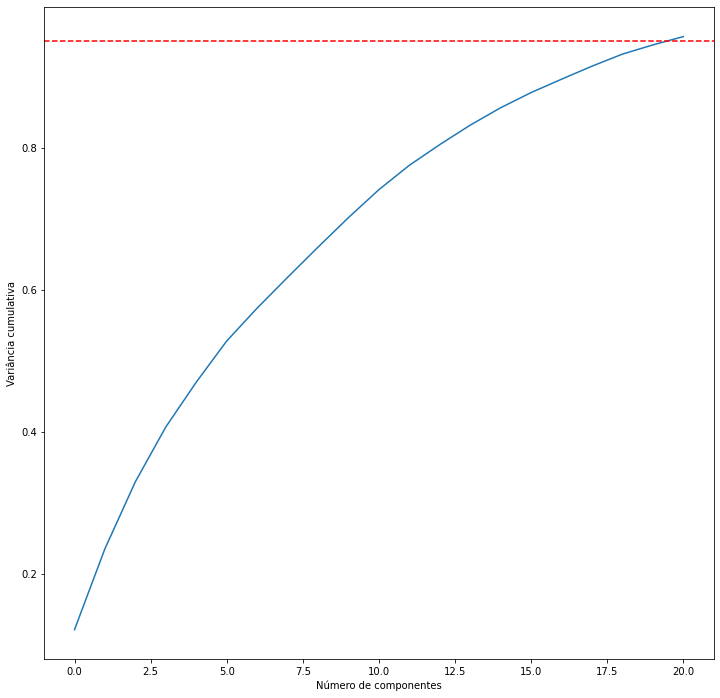

In [267]:
g = sns.lineplot(np.arange(len(evr)), np.cumsum(evr))
g.axes.axhline(0.95, ls="--", color="red")
plt.xlabel('Número de componentes')
plt.ylabel('Variância cumulativa');

### **Aplicação do Algoritmo**

O objetivo de nossa análise é promover um produto capaz de fornecer um serviço de recomendação de leads para um usuário dado um portifólio de clientes. Para esse tipo de problema a utilização de um algoritmo de clusterização parece ser o mais adequado. Desta forma utilizaremos o [Kmeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

#### **KMeans**

O Kmeans é um dos algoritmos de aprendendizagem não superviosionado mais famosos. Entretando para sua aplicação é necessário dizer o número de clusters a ser utilizado na análise, senão por *default* são setados 8 clusters. Entretanto, 8 clusters é o valor padrão para rodarmos o algoritmo de forma a não disperdiçar recursos a matemática nos auxilia com alguns métodos para verificar o número ótimo de clusters. Um desses métodos é o método do cotovelo.

**Método do Cotovelo**

O [método do cotovelo](https://medium.com/pizzadedados/kmeans-e-metodo-do-cotovelo-94ded9fdf3a9) tem como finalidade verificar o número ótimo de clusters para que o algoritmo tenha a melhor performance. O método do cotovelo consiste em aplicar o KMeans para diversos valores de clusters e verificar em qual dessas análises a distância intra-clusters(*within-clusters sum-of-squares* (wcss)) é a menor possível, sendo 0 o nosso valor ótimo. 

* wcss: o skLearn já calcula esse valor e o nomeia de *inertia*. A inertia é uma métrica não normalizada que assume que nossos cluster são convexos e isotrópicos, logo em datasets com muitas dimensões pode ser uma métrica que não se aplica muito bem já que as distâncias ficam infladas.


Temos os clusters de 2 até 8 e para cada valor de k calcularemos a soma dos quadrados intra-cluster. 

In [0]:
x1, x2 = 2, 8
var_range = range(x1,x2+1)

k = 8

wcss_calculate = []
for n in range(2, 9): 
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X_market)
    wcss_calculate.append(kmeans.inertia_)

Vamos visualizar a curva da soma dos quadrados e acordo com o número de clusters k. O ponto que "dobra o cotovelo" é  considerado um indicador do número de clusters. Acontece que o ponto que indica o equilíbrio entre maior homogeneidade dentro do cluster e a maior diferença entre clusters, é o ponto da curva mais distante de uma reta traçada entre os pontos a0 e a8.

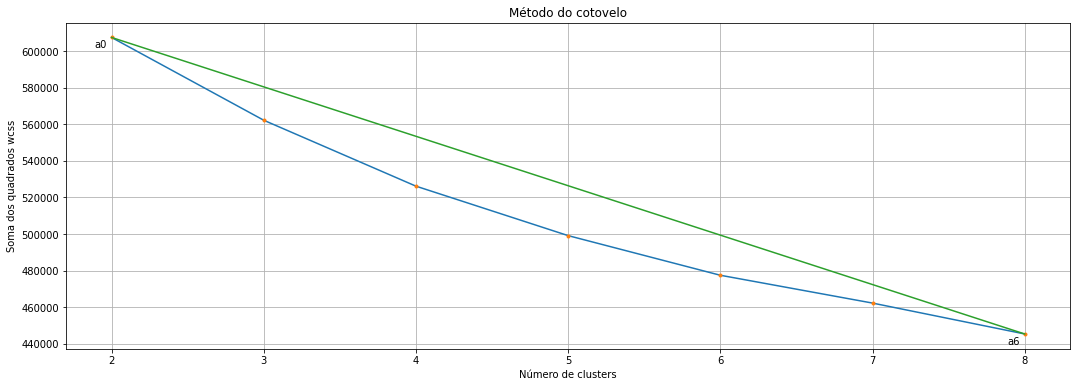

In [269]:
plt.figure(figsize=(18,6))
plt.title('Método do cotovelo')
plt.xlabel('Número de clusters')
plt.ylabel('Soma dos quadrados wcss')
plt.grid()
plt.xticks(var_range)
plt.plot(var_range, wcss_calculate)      
plt.plot(var_range, wcss_calculate, '.') 

y2 = wcss_calculate[len(wcss_calculate)-1]
y1 = wcss_calculate[0]

plt.plot([x2, x1], [y2,y1])                   
for x,y in zip(var_range,wcss_calculate):   
    label = "a{}".format(x-2)
    if label in ['a0', 'a6']:
        plt.annotate(label,
                     (x,y),
                     textcoords="offset points",
                     xytext=(-5,-10),
                     ha='right')
plt.show()

Através da fórmula abaixo calculamos a distância entre a0 e a8.



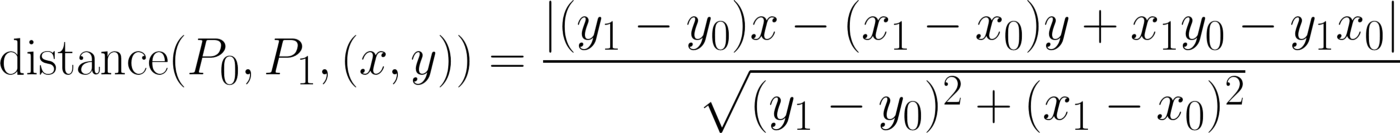

In [0]:
def optimal_number_of_clusters(wcss_calculate):
    x1, y1 = 2, wcss_calculate[0]
    x2, y2 = 8, wcss_calculate[len(wcss_calculate)-1]

    distances = []
    for i in range(len(wcss_calculate)):
        x0 = i+2
        y0 = wcss_calculate[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

Verificando o número de clusters ótimo.

In [271]:
n= optimal_number_of_clusters(wcss_calculate)
n

5

In [0]:
kmeans = KMeans(n_clusters=n, random_state=42) 
cl = kmeans.fit(X_market)

**Verificando nossos clusters**

O nosso algoritmo diz que o número ótimo de clusters na nossa análise é 5. Vamos visualizar a distribuição de nossos clusters de forma gráfica: 

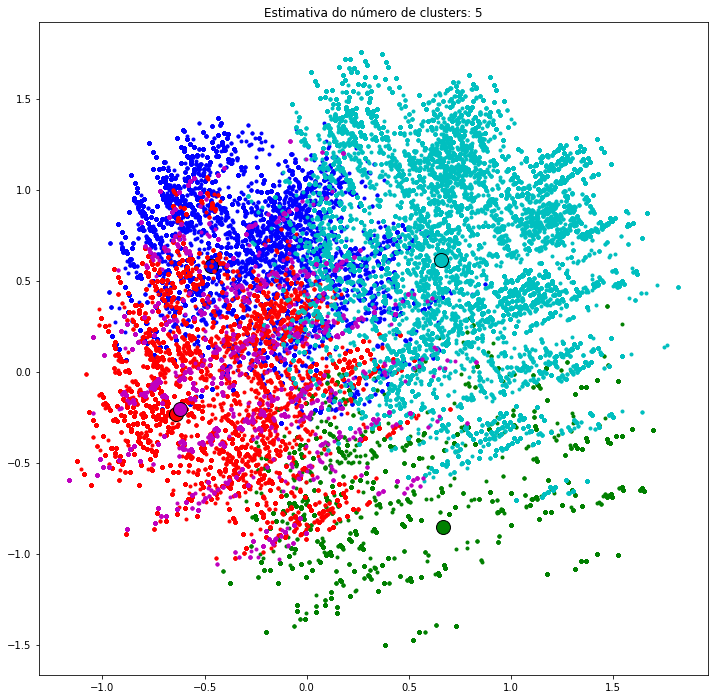

In [273]:
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(len(np.unique(cl.labels_))), colors):
    my_members = cl.labels_ == k
    cluster_center = cl.cluster_centers_[k]
    plt.plot(X_market[my_members, 0], X_market[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimativa do número de clusters: %d' % len(np.unique(cl.labels_)))
plt.show()

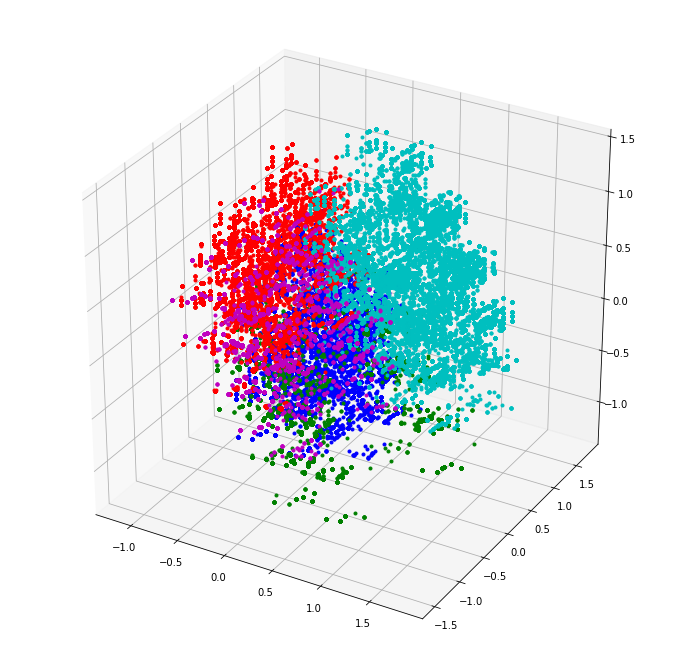

In [274]:
from __future__ import division
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z_offset = 3

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(len(np.unique(cl.labels_))), colors):
    my_members = cl.labels_ == k
    cluster_center = cl.cluster_centers_[k]
    ax.plot(X_market[my_members, 0], X_market[my_members, 1], X_market[my_members, 2], col + '.')

O método do cotovelo nos diz que o número ótimo de clusters é 5, entretanto ao analisar os nossos gráficos verificamos que existem 2 clusters que ocupam a mesma área, ou seja, englobam praticamente as mesmas empresas. Então, por acreditarem que ambos apresentem grande parte das informações redundantes então adotaremos 4 clusters na nossa análise. 

**Distribuição para 4 clusters**

É importante ressaltar que por mais que o método do cotovelo seja muito difundido é importante termos o senso crítico de analisar seu resultado.

In [0]:
n_cl = 4

In [0]:
kmeans = KMeans(n_clusters=n_cl, random_state=42) 
cl = kmeans.fit(X_market)

In [277]:
cl

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

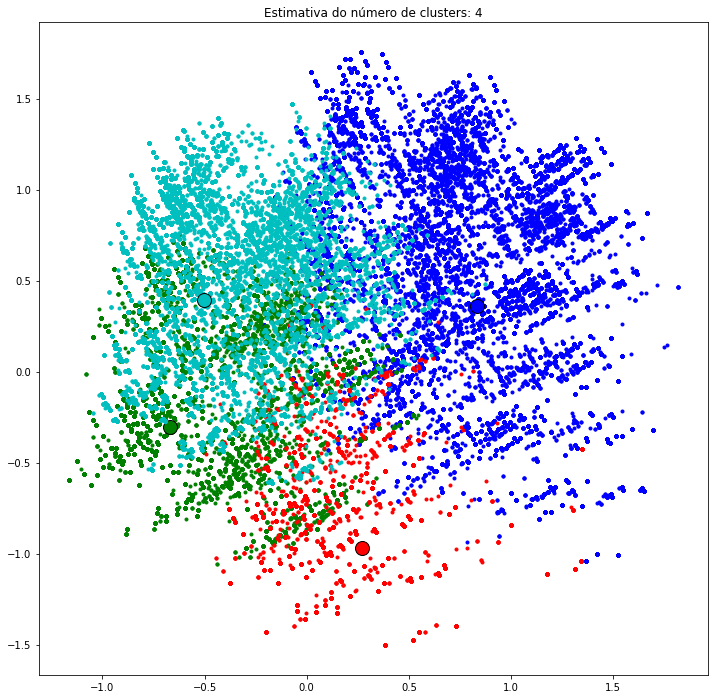

In [278]:
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(len(np.unique(cl.labels_))), colors):
    my_members = cl.labels_ == k
    cluster_center = cl.cluster_centers_[k]
    plt.plot(X_market[my_members, 0], X_market[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimativa do número de clusters: %d' % len(np.unique(cl.labels_)))
plt.show()

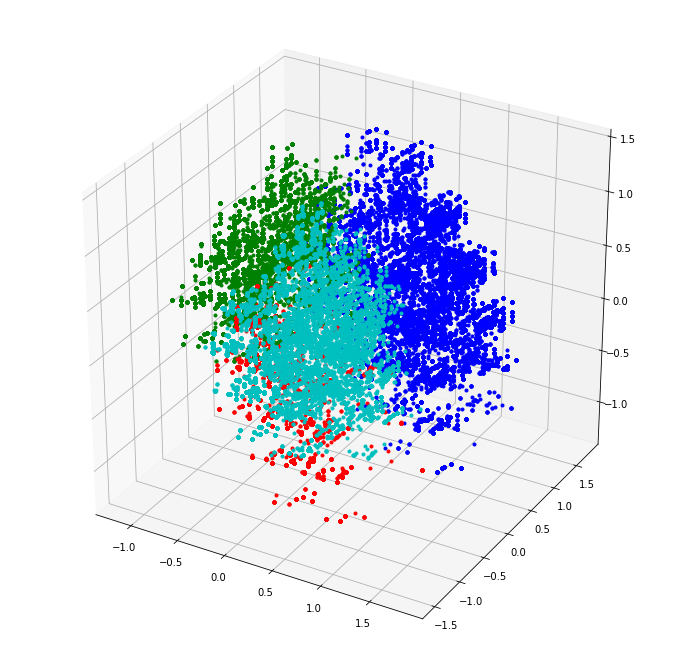

In [279]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z_offset = 3

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(len(np.unique(cl.labels_))), colors):
    my_members = cl.labels_ == k
    cluster_center = cl.cluster_centers_[k]
    ax.plot(X_market[my_members, 0], X_market[my_members, 1], X_market[my_members, 2], col + '.')

Podemos verificar através de nosso gráfico que a distribuição das empresas com 4 clusters é melhor distribuída.

### **Aplicação do KMeans**

Vamos verificar a distribuição de nossos 4 clusters. 

Text(0.5, 1.0, 'Clusters')

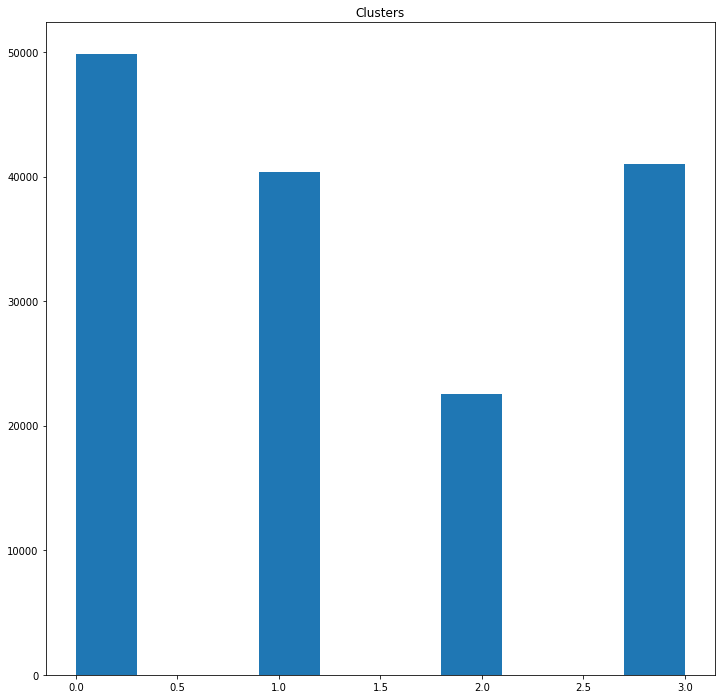

In [280]:
df_market_cluster = pd.DataFrame(df_market_dummies.index)
df_market_cluster['clusters'] = cl.labels_

plt.hist(df_market_cluster['clusters'])
plt.title('Clusters')

In [281]:
df_market_cluster.head()

,id,clusters
0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,0
1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,3
2,4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02...,2
3,3348900fe63216a439d2e5238c79ddd46ede454df7b9d8...,3
4,1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4...,0


### **Treinando nosso modelo**

Vamos utilizar os 3 portifólios disponíveís para treinar o nosso modelo de predição.

**Importando os datasets de treinos**

In [0]:
df_pf_1 = pd.read_csv('/content/drive/My Drive/data/estaticos_portfolio1.csv')
df_pf_2 = pd.read_csv('/content/drive/My Drive/data/estaticos_portfolio2.csv')
df_pf_3 = pd.read_csv('/content/drive/My Drive/data/estaticos_portfolio3.csv')

**Mapeando nossos portifólios**

Temos 3 portifólios para treinar nosso modelo e 4 clusters. Então, inicialmente vamos fazer a análise de cada portifólio, onde :

* Mapear nossos clusters do portifólio analisado para verificar em quais cluster se encaixam as empresas do portifólio analisado.
* Remover as empresas do portifólio do mercado.
* Apresentar a distribuição das empresas que se encontram em nosso portifólio pelos clusters estabelecidos.

#### **Portifólio 1**

Nosso primeiro portifólio possui 182 colunas e 555 linhas com variáveis do tipo booleana, float, int e variáveis categóricas.

In [283]:
df_pf_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555 entries, 0 to 554
Columns: 182 entries, Unnamed: 0 to qt_filiais
dtypes: bool(14), float64(142), int64(4), object(22)
memory usage: 736.2+ KB


Text(0.5, 1.0, 'Clusters')

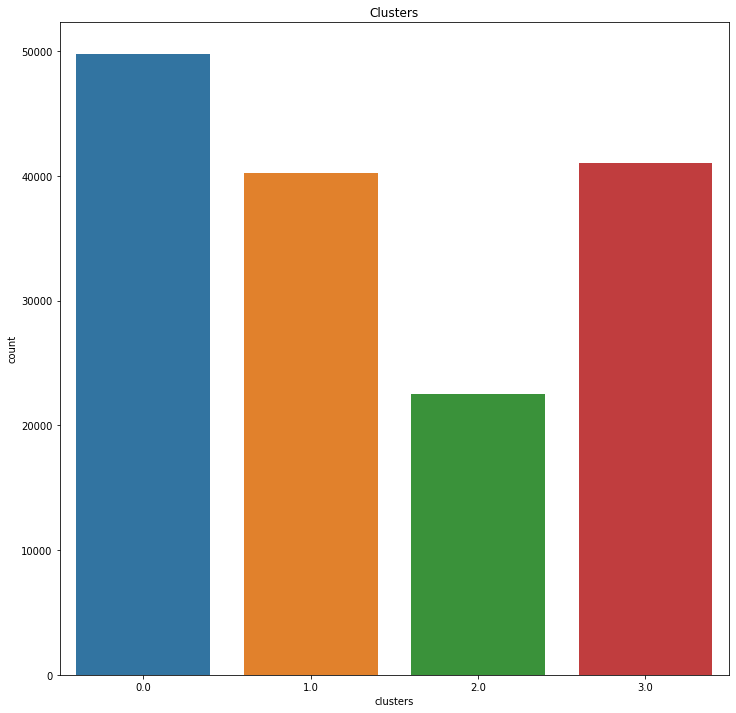

In [284]:
df_pf1_clusters = pd.merge(df_pf_1, df_market_cluster, on='id', how='left')
df_market_pf1 = pd.concat([df_pf1_clusters[['id', 'clusters']], df_market_cluster]).drop_duplicates(keep=False)

plt.figure()
sns.countplot(x='clusters', data=df_market_pf1);
plt.title('Clusters')

Vamos verificar os valores de distribuição das empresas nos nossos clusters. Como podemos verificar a maioria das empresas se encontram no cluster 0.

In [285]:
df_value_cluster = pd.DataFrame(df_market_pf1['clusters'].value_counts(normalize=True))
df_value_cluster

,clusters
0.0,0.324183
3.0,0.267015
1.0,0.262096
2.0,0.146706


Vamos verificar no nosso portifólio em que cluster se encontram as empresas com maior probabilidade de aderência ao nosso modelo.

In [286]:
order_clusters_prob= list(df_value_cluster.T.columns)
rec_list_pf1 = df_market_pf1.loc[order_clusters_prob]
rec_list_pf1.head()

,id,clusters
0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,0.0
3,3348900fe63216a439d2e5238c79ddd46ede454df7b9d8...,3.0
1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,3.0
2,4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02...,2.0


Como podemos observar através da nossa lista ordenada o cluster 3 é o que possui maior aderência ao nosso modelo e não o cluster 0.

#### **Portifólio 2**

Nosso portifólio 2 possui 2 colunas e 566 linhas, sendo elas o id da empresa e o index (Unnamed:0).

In [287]:
df_pf_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  566 non-null    int64 
 1   id          566 non-null    object
dtypes: int64(1), object(1)
memory usage: 9.0+ KB


Text(0.5, 1.0, 'Clusters')

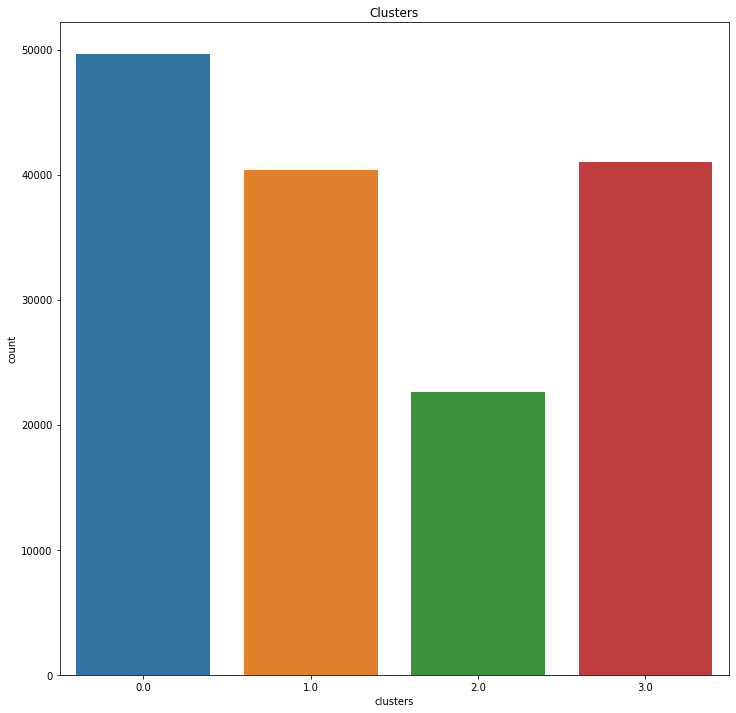

In [288]:
df_pf2_clusters = pd.merge(df_pf_2, df_market_cluster, on='id', how='left')
df_market_pf2 = pd.concat([df_pf2_clusters[['id', 'clusters']], df_market_cluster]).drop_duplicates(keep=False)

plt.figure()
sns.countplot(x='clusters', data=df_market_pf2);
plt.title('Clusters')

In [289]:
df_value_cluster = pd.DataFrame(df_market_pf2['clusters'].value_counts(normalize=True))
df_value_cluster

,clusters
0.0,0.323392
3.0,0.266952
1.0,0.262696
2.0,0.146960


Como podemos verificar a maior parte das nossas empresas tem aderência ao cluster 3.0. Assim, como no nosso primeiro portifólio.

In [290]:
order_clusters_prob = list(df_value_cluster.T.columns)
rec_port_2 = df_market_pf2.loc[order_clusters_prob]
rec_port_2.head()

,id,clusters
0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,0.0
3,3348900fe63216a439d2e5238c79ddd46ede454df7b9d8...,3.0
1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,3.0
2,4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02...,2.0


#### **Portifólio 3**

O nosso portifólio 3 é semelhante ao nosso portifólio 2, entretando possui menos linhas, neste caso 264.



In [291]:
df_pf_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  265 non-null    int64 
 1   id          265 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.3+ KB


Text(0.5, 1.0, 'Clusters')

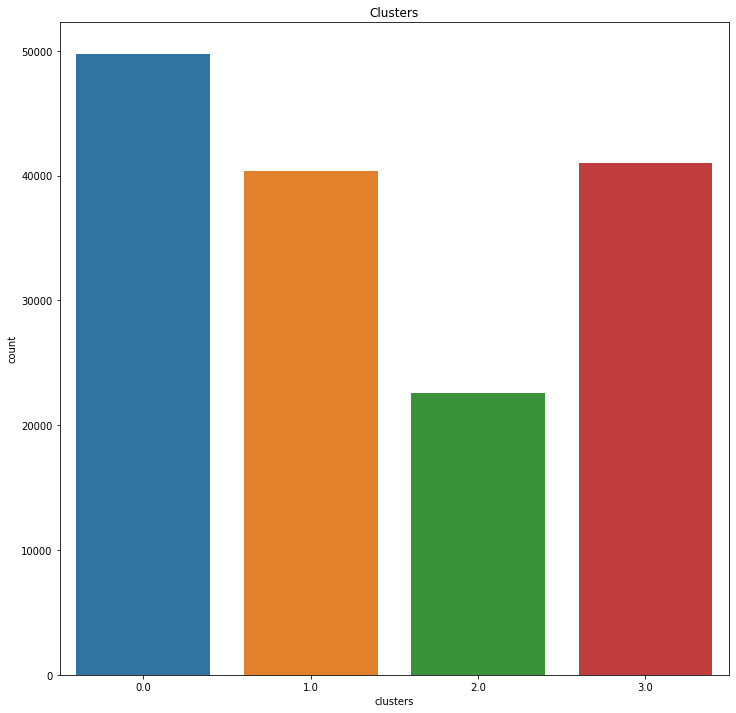

In [292]:
df_pf3_clusters = pd.merge(df_pf_3, df_market_cluster, on='id', how='left')
df_market_pf3 = pd.concat([df_pf3_clusters[['id', 'clusters']], df_market_cluster]).drop_duplicates(keep=False)

plt.figure()
sns.countplot(x='clusters', data=df_market_pf3);
plt.title('Clusters')

In [293]:
df_value_cluster = pd.DataFrame(df_market_pf3['clusters'].value_counts(normalize=True))
df_value_cluster

,clusters
0.0,0.323804
3.0,0.266825
1.0,0.262513
2.0,0.146857


In [294]:
order_clusters_prob = list(df_value_cluster.T.columns)
rec_port_3 = df_market_pf3.loc[order_clusters_prob]
rec_port_3.head()

,id,clusters
0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,0.0
3,3348900fe63216a439d2e5238c79ddd46ede454df7b9d8...,3.0
1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,3.0
2,4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02...,2.0


Como podemos veririficar o Portifólio 3 as variáveis possuem mais aderência ao cluster 3.0.

#### **Características dos clusters**

A variável **id** segue sendo a mesma para o dataset de portifólios e o dataset do mercado, é possível segmentar o meu dataset mercado pelos clusters criados, retornando as principais características de cada cluster.

In [0]:
df_market_c0 = df_market_cluster[df_market_cluster.clusters == 0]
df_market_c1 = df_market_cluster[df_market_cluster.clusters == 1]
df_market_c2 = df_market_cluster[df_market_cluster.clusters == 2]
df_market_c3 = df_market_cluster[df_market_cluster.clusters == 3]

Vamos fazer o merge de nossos datasets contendo as colunas originais.

In [0]:
df_market_cluster_total = pd.merge(df_market_cluster,df_market, on='id', how='left')

df_market_cluster0 = pd.merge(df_market_c0,df_market, on='id', how='left')
df_market_cluster1 = pd.merge(df_market_c1,df_market, on='id', how='left')
df_market_cluster2 = pd.merge(df_market_c2,df_market, on='id', how='left')
df_market_cluster3 = pd.merge(df_market_c3,df_market, on='id', how='left')


df_pf1_total = pd.merge(df_pf1_clusters, df_market, on='id', how='left')
df_pf2_total = pd.merge(df_pf2_clusters, df_market, on='id', how='left')
df_pf3_total = pd.merge(df_pf3_clusters, df_market, on='id', how='left')

Vamos normalizar individualmente cada variável em cada um desses datasets (portifólios) para saber qual a porcentagem de cada uma das variáveis (escolhidas) possuímos em nossos datasets de treino.

* Criando nossos datasets

In [0]:
df_sg_uf_norm = pd.DataFrame(columns=['C0','C1','C2','C3'])
df_natureza_juridica_macro_norm= pd.DataFrame(columns=['C0','C1','C2','C3'])
df_setor_norm= pd.DataFrame(columns=['C0','C1','C2','C3'])
df_idade_emp_cat_norm= pd.DataFrame(columns=['C0','C1','C2','C3'])
df_de_saude_tributaria_norm= pd.DataFrame(columns=['C0','C1','C2','C3'])
df_de_nivel_atividade_norm= pd.DataFrame(columns=['C0','C1','C2','C3'])
df_faixa_faturamento_estimado_grupo_norm= pd.DataFrame(columns=['C0','C1','C2','C3'])

* Análise de cada uma das nossas variáveis


**sg_uf_norm**

In [0]:
df_sg_uf_norm['C0'] = df_market_cluster0.sg_uf.value_counts(normalize=True)*100
df_sg_uf_norm['C1'] = df_market_cluster1.sg_uf.value_counts(normalize=True)*100
df_sg_uf_norm['C2'] = df_market_cluster2.sg_uf.value_counts(normalize=True)*100
df_sg_uf_norm['C3'] = df_market_cluster3.sg_uf.value_counts(normalize=True)*100

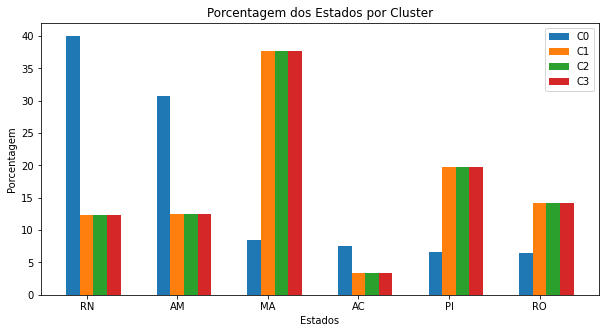

In [299]:
barWidth = 0.15

r1 = np.arange(len(df_sg_uf_norm))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]


plt.figure(figsize=(10,5))
plt.bar(r1, df_sg_uf_norm.C0, width=barWidth, label='C0')
plt.bar(r2, df_sg_uf_norm.C1, width=barWidth, label='C1')
plt.bar(r3, df_sg_uf_norm.C1, width=barWidth, label='C2')
plt.bar(r4, df_sg_uf_norm.C1, width=barWidth, label='C3')


plt.xlabel('Estados')
plt.xticks([r + barWidth for r in range(len(df_sg_uf_norm))], 
          df_sg_uf_norm.index.tolist())
plt.ylabel('Porcentagem')
plt.title('Porcentagem dos Estados por Cluster')

plt.legend(df_sg_uf_norm.columns,loc='upper right')

Quase 40% das empresas do cluster C0 se encontram no estado de Rondônia (RN) enquanto a maioria das empresas dos nossos clusters se encontram contidas no Maranhão, o que indica a predominância dessas empressa no Nordeste. 

Para termos uma melhor vizualização vamos plotar os gráficos antes dos dados serem normalizados

**natureza_juridica_macro**

In [0]:
df_natureza_juridica_macro_norm['C0'] = df_market_cluster0.natureza_juridica_macro.value_counts(normalize=True)*100
df_natureza_juridica_macro_norm['C1'] = df_market_cluster1.natureza_juridica_macro.value_counts(normalize=True)*100
df_natureza_juridica_macro_norm['C2'] = df_market_cluster2.natureza_juridica_macro.value_counts(normalize=True)*100
df_natureza_juridica_macro_norm['C4'] = df_market_cluster3.natureza_juridica_macro.value_counts(normalize=True)*100

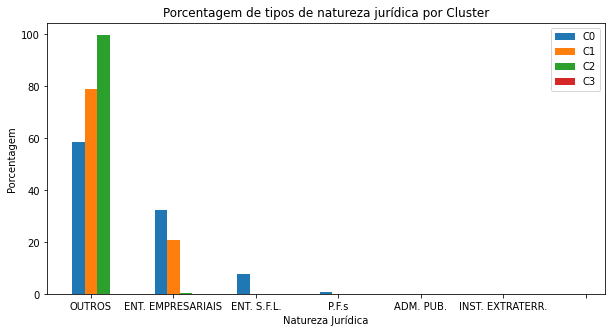

In [301]:
barWidth = 0.15

r1 = np.arange(len(df_natureza_juridica_macro_norm))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]


plt.figure(figsize=(10,5))
plt.bar(r1, df_natureza_juridica_macro_norm.C0, width=barWidth, label='C0')
plt.bar(r2, df_natureza_juridica_macro_norm.C1, width=barWidth, label='C1')
plt.bar(r3, df_natureza_juridica_macro_norm.C2, width=barWidth, label='C2')
plt.bar(r4, df_natureza_juridica_macro_norm.C3, width=barWidth, label='C3')


plt.xlabel('Natureza Jurídica')
plt.xticks([r + barWidth for r in range(len(df_natureza_juridica_macro_norm))], 
          ['OUTROS','ENT. EMPRESARIAIS','ENT. S.F.L.','P.F.s','ADM. PUB.','INST. EXTRATERR.'])
plt.ylabel('Porcentagem')
plt.title('Porcentagem de tipos de natureza jurídica por Cluster')
plt.legend(df_natureza_juridica_macro_norm.columns,loc='upper right')

A maior parte de nossas empresas em relação a sua natureza jurídica se encontram concentrados na categoria Outros.

**setor**

In [0]:
df_setor_norm['C0'] = df_market_cluster0.setor.value_counts(normalize=True)*100
df_setor_norm['C1'] = df_market_cluster1.setor.value_counts(normalize=True)*100
df_setor_norm['C2'] = df_market_cluster2.setor.value_counts(normalize=True)*100
df_setor_norm['C3'] = df_market_cluster3.setor.value_counts(normalize=True)*100

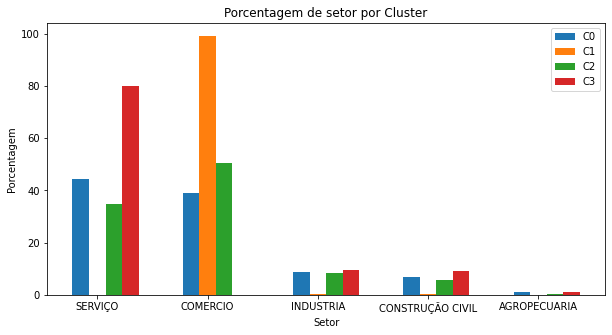

In [303]:
barWidth = 0.15

r1 = np.arange(len(df_setor_norm))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]


plt.figure(figsize=(10,5))
plt.bar(r1, df_setor_norm.C0, width=barWidth, label='C0')
plt.bar(r2, df_setor_norm.C1, width=barWidth, label='C1')
plt.bar(r3, df_setor_norm.C2, width=barWidth, label='C2')
plt.bar(r4, df_setor_norm.C3, width=barWidth, label='C1')


plt.xlabel('Setor')
plt.xticks([r + barWidth for r in range(len(df_setor_norm))], 
          df_setor_norm.index.tolist())
plt.ylabel('Porcentagem')
plt.title('Porcentagem de setor por Cluster')
plt.legend(df_setor_norm.columns,loc='upper right')

A maioria de nossas empresas se encontram concentradas no setor de Serviços e Comercio.

**idade_emp_cat**

In [0]:
df_idade_emp_cat_norm['C0'] = df_market_cluster0.idade_emp_cat.value_counts(normalize=True)*100
df_idade_emp_cat_norm['C1'] = df_market_cluster1.idade_emp_cat.value_counts(normalize=True)*100
df_idade_emp_cat_norm['C2'] = df_market_cluster2.idade_emp_cat.value_counts(normalize=True)*100
df_idade_emp_cat_norm['C3'] = df_market_cluster3.idade_emp_cat.value_counts(normalize=True)*100

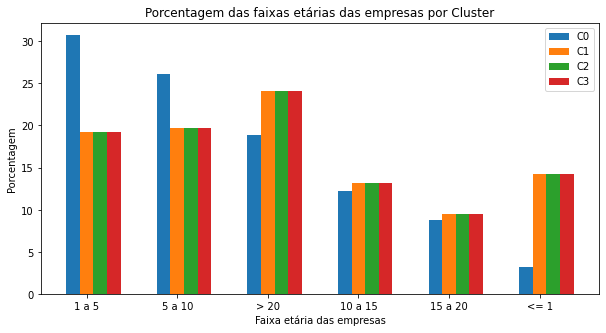

In [305]:
barWidth = 0.15

r1 = np.arange(len(df_idade_emp_cat_norm))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.figure(figsize=(10,5))
plt.bar(r1, df_idade_emp_cat_norm.C0, width=barWidth, label='C0')
plt.bar(r2, df_idade_emp_cat_norm.C1, width=barWidth, label='C1')
plt.bar(r3, df_idade_emp_cat_norm.C1, width=barWidth, label='C2')
plt.bar(r4, df_idade_emp_cat_norm.C1, width=barWidth, label='C3')

plt.xlabel('Faixa etária das empresas')
plt.xticks([r + barWidth for r in range(len(df_idade_emp_cat_norm))], 
          df_idade_emp_cat_norm.index.tolist())
plt.ylabel('Porcentagem')
plt.title('Porcentagem das faixas etárias das empresas por Cluster')
plt.legend(df_idade_emp_cat_norm.columns,loc='upper right')

A maioria das empresas de nosso dataset, contidas em nossos 2 clusters são empresas jovens, que se encontram enquadradas na faixa etária de 1 até 5 anos.

**de_saude_tributaria**

In [0]:
df_de_saude_tributaria_norm['C0'] = df_market_cluster0.de_saude_tributaria.value_counts(normalize=True)*100
df_de_saude_tributaria_norm['C1'] = df_market_cluster1.de_saude_tributaria.value_counts(normalize=True)*100
df_de_saude_tributaria_norm['C2'] = df_market_cluster2.de_saude_tributaria.value_counts(normalize=True)*100
df_de_saude_tributaria_norm['C3'] = df_market_cluster3.de_saude_tributaria.value_counts(normalize=True)*100

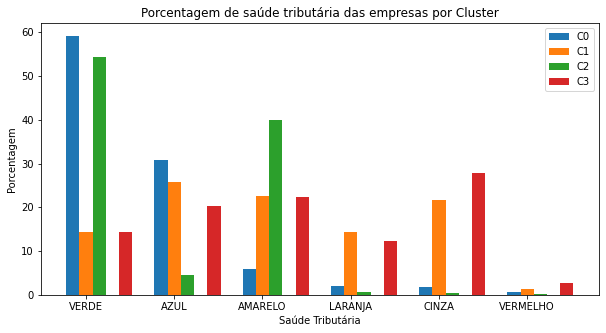

In [307]:
barWidth = 0.15

r1 = np.arange(len(df_de_saude_tributaria_norm))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r4]

plt.figure(figsize=(10,5))
plt.bar(r1, df_de_saude_tributaria_norm.C0, width=barWidth, label='C0')
plt.bar(r2, df_de_saude_tributaria_norm.C1, width=barWidth, label='C1')
plt.bar(r3, df_de_saude_tributaria_norm.C2, width=barWidth, label='C2')
plt.bar(r4, df_de_saude_tributaria_norm.C3, width=barWidth, label='C3')


plt.xlabel('Saúde Tributária')
plt.xticks([r + barWidth for r in range(len(df_de_saude_tributaria_norm))], 
          df_de_saude_tributaria_norm.index.tolist())
plt.ylabel('Porcentagem')
plt.title('Porcentagem de saúde tributária das empresas por Cluster')
plt.legend(df_setor_norm.columns,loc='upper right')

Aproximadamente 60% empresas de nosso cluster 0 se encontram com uma saúde financeira boa (VERDE).

**de_nivel_atividade**

In [0]:
df_de_nivel_atividade_norm['C0'] = df_market_cluster0.de_nivel_atividade.value_counts(normalize=True)*100
df_de_nivel_atividade_norm['C1'] = df_market_cluster1.de_nivel_atividade.value_counts(normalize=True)*100
df_de_nivel_atividade_norm['C2'] = df_market_cluster2.de_nivel_atividade.value_counts(normalize=True)*100
df_de_nivel_atividade_norm['C3'] = df_market_cluster3.de_nivel_atividade.value_counts(normalize=True)*100

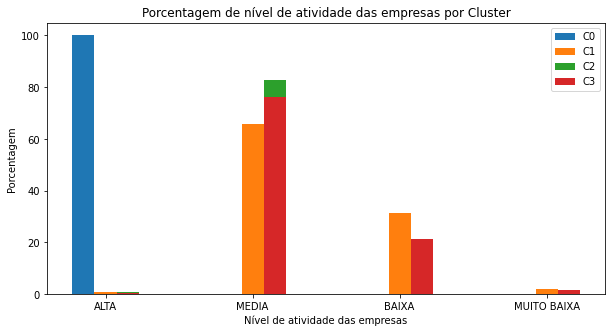

In [309]:
barWidth = 0.15

r1 = np.arange(len(df_de_nivel_atividade_norm))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.figure(figsize=(10,5))
plt.bar(r1, df_de_nivel_atividade_norm.C0, width=barWidth, label='C0')
plt.bar(r2, df_de_nivel_atividade_norm.C1, width=barWidth, label='C1')
plt.bar(r3, df_de_nivel_atividade_norm.C2, width=barWidth, label='C2')
plt.bar(r3, df_de_nivel_atividade_norm.C3, width=barWidth, label='C3')


plt.xlabel('Nível de atividade das empresas')
plt.xticks([r + barWidth for r in range(len(df_de_nivel_atividade_norm))], 
          df_de_nivel_atividade_norm.index.tolist())
plt.ylabel('Porcentagem')
plt.title('Porcentagem de nível de atividade das empresas por Cluster')
plt.legend(df_de_nivel_atividade_norm.columns,loc='upper right')

Todas as empresas do Cluster 0 possuem um nível de atividade classificada como ALTA. 

**de_faixa_faturamento_estimado_grupo**

In [0]:
df_faixa_faturamento_estimado_grupo_norm['C0'] = df_market_cluster0.de_faixa_faturamento_estimado_grupo.value_counts(normalize=True)*100
df_faixa_faturamento_estimado_grupo_norm['C1'] = df_market_cluster1.de_faixa_faturamento_estimado_grupo.value_counts(normalize=True)*100
df_faixa_faturamento_estimado_grupo_norm['C2'] = df_market_cluster2.de_faixa_faturamento_estimado_grupo.value_counts(normalize=True)*100
df_faixa_faturamento_estimado_grupo_norm['C3'] = df_market_cluster3.de_faixa_faturamento_estimado_grupo.value_counts(normalize=True)*100

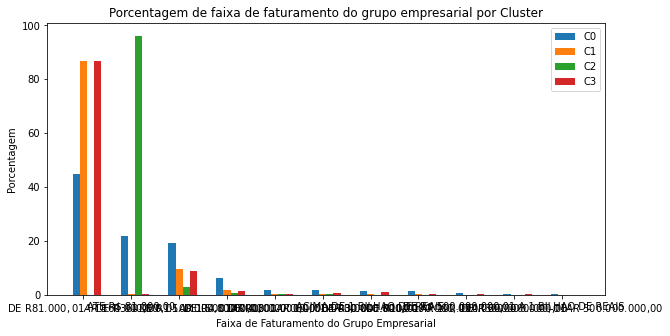

In [311]:
barWidth = 0.15

r1 = np.arange(len(df_faixa_faturamento_estimado_grupo_norm))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.figure(figsize=(10,5))
plt.bar(r1, df_faixa_faturamento_estimado_grupo_norm.C0, width=barWidth, label='C0')
plt.bar(r2, df_faixa_faturamento_estimado_grupo_norm.C1, width=barWidth, label='C1')
plt.bar(r3, df_faixa_faturamento_estimado_grupo_norm.C2, width=barWidth, label='C2')
plt.bar(r4, df_faixa_faturamento_estimado_grupo_norm.C3, width=barWidth, label='C3')

plt.xlabel('Faixa de Faturamento do Grupo Empresarial')
plt.xticks([r + barWidth for r in range(len(df_faixa_faturamento_estimado_grupo_norm))], 
          df_faixa_faturamento_estimado_grupo_norm.index.tolist())
plt.ylabel('Porcentagem')
plt.title('Porcentagem de faixa de faturamento do grupo empresarial por Cluster')
plt.legend(df_faixa_faturamento_estimado_grupo_norm.columns,loc='upper right')

A maioria das nossas empresas possuem uma faixa de faturamento de 81.000,01 até R$ 360.000,00.


### **Resultados do Modelo**

Vamos realizar análises para cada um dos portifólios. Mas antes vamos criar algumas variáveis auxiliariares.

* Vamos pegar as quantidades de empresas em cada um dos portifólios.


In [0]:
p1_num_empresas_cl = df_market_pf1.clusters.value_counts()
p2_num_empresas_cl = df_market_pf2.clusters.value_counts()
p3_num_empresas_cl = df_market_pf3.clusters.value_counts()

In [0]:
market_num_empresas_c0 = df_market_c0.clusters.value_counts()
market_num_empresas_c1 = df_market_c1.clusters.value_counts()
market_num_empresas_c2 = df_market_c2.clusters.value_counts()
market_num_empresas_c3 = df_market_c3.clusters.value_counts()

**Análise do Portifólio 1**

Como verificamos anteriormente o Cluster 3 é o que contém a maior quantidade dos valores no portifólio 1. 

In [0]:
df_p1_total_C3 = df_pf1_clusters[df_pf1_clusters.clusters == 3]

In [0]:
df_p1_total_C3.rename(columns={'de_faixa_faturamento_estimado_grupo_y':'de_faixa_faturamento_estimado_grupo'}, inplace=True)
df_p1_total_C3.rename(columns={'idade_emp_cat_y':'idade_emp_cat'}, inplace=True)

Vamos verificar agora a quantidade de empresas disponíveis por cluster presentes no Portifólio 1.

In [316]:
p1_num_empresas_cl

0.0    49823
3.0    41037
1.0    40281
2.0    22547
Name: clusters, dtype: int64

Agora vamos verificar a quantidade de empresas que estão presentes no dataset *Market* e estão  no nosso cluster 3.

In [317]:
market_num_empresas_c3


3    41042
Name: clusters, dtype: int64

Agora vamos verificar a acurácia de nosso modelo: qual a porcentagem de empresas que são do Cluster 3 e são clientes no Portifólio 1.

In [318]:
leads_pf1 = p1_num_empresas_cl/market_num_empresas_c3*100
leads_pf1

0.0          NaN
1.0          NaN
2.0          NaN
3.0    99.987817
Name: clusters, dtype: float64

Nosso cluster 3 engloba 99,98% das empresas presentes no portifólio 1.

**Portifólio 2**

Como vimos anteriormente o Cluster 3 possui as variáveis com maior probabilidade de aderirem ao modelo.

In [0]:
df_p2_total_C3 = df_pf2_clusters[df_pf2_clusters.clusters == 3]

In [0]:
df_p2_total_C3.rename(columns={'de_faixa_faturamento_estimado_grupo_y':'de_faixa_faturamento_estimado_grupo'}, inplace=True)
df_p2_total_C3.rename(columns={'idade_emp_cat_y':'idade_emp_cat'}, inplace=True)

Agora vamos verificar a quantidade de empresas presentes no Portifólio 2 disponíveis por cluster. É importante ressaltarmos que o cluster que possui o maior número de variáveis é o cluster 0, entretanto ao verificar as empresas que possuem a maior probabilidade de aderirem ao modelo verificamos que o Cluster 3 representa uma melhor possibilidade. 

In [321]:
p2_num_empresas_cl

0.0    49695
3.0    41022
1.0    40368
2.0    22583
Name: clusters, dtype: int64

Agora vamos verificar as empresas que estão presentes no dataset *Market* e no cluster 3

In [322]:
market_num_empresas_c3

3    41042
Name: clusters, dtype: int64

Agora vamos verificar a porcentagem de empresas presentes no nosso cluster 3, que estão presentes no portifólio 2

In [323]:
leads_pf2 = p2_num_empresas_cl/market_num_empresas_c3*100
leads_pf2

0.0          NaN
1.0          NaN
2.0          NaN
3.0    99.951269
Name: clusters, dtype: float64

**Portifólio 3**

Para o portifílio 3 o cluster que possui maior aderência é o cluster 3. Logo, assim como nos portifólios anteriores o dataset market possui 41042 empresas presentes nesse cluster. 

Agora vamos verificar a porcetagem das empresas presentes no cluster 3 e no portifólio 3.

In [324]:
leads_pf3 = p3_num_empresas_cl/market_num_empresas_c3*100
leads_pf3

0.0          NaN
1.0          NaN
2.0          NaN
3.0    99.973198
Name: clusters, dtype: float64

O Portifólio 3 possui 99.97% de suas empresas contidas no cluster 3.